In [62]:
import pandas as pd
import numpy as np

In [63]:
df = pd.read_csv('data/dataproject2025.csv')

In [64]:
df.head()

,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,...,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,...,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,...,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,...,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,...,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


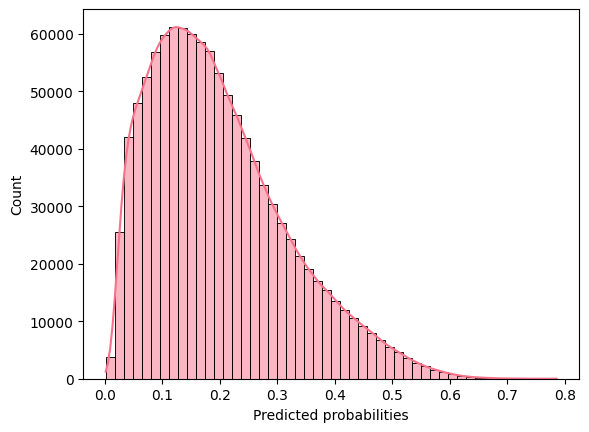

Variance of Predicted Probabilities: 0.014108535581606923


In [65]:
sns.histplot(df['Predicted probabilities'], bins=50, kde=True)
plt.show()

variance = df['Predicted probabilities'].var()
print("Variance of Predicted Probabilities:", variance)

In [66]:
# Filter the probabilities based on Predictions
prob_0 = df[df['Predictions'] == 0]['Predicted probabilities']
prob_1 = df[df['Predictions'] == 1]['Predicted probabilities']

# Find the threshold
threshold = (prob_0.max() + prob_1.min()) / 2
print("Threshold:", threshold)

Threshold: 0.30135495154138175


# Surrogate Model Analysis for Black-Box Model Interpretation

We'll implement surrogate models to interpret the unknown model that generated the Default Probabilities (DP).
The DP column is the `Predicted probabilities` which represents the original model's output.

In [67]:
# Import required libraries for surrogate modeling with TableVectorizer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from skrub import TableVectorizer  # For automated preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [68]:
# Prepare data for surrogate modeling
print("Dataset columns:")
print(df.columns.tolist())
print(f"\nDataset shape: {df.shape}")

# The target variable for surrogate models is the DP (Predicted probabilities)
target_col = 'Predicted probabilities'
print(f"\nTarget variable (DP): {target_col}")
print(f"DP statistics:")
print(df[target_col].describe())

Dataset columns:
['Unnamed: 0', 'issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']

Dataset shape: (1086236, 39)

Target variable (DP): Predicted probabilities
DP statistics:
count    1.086236e+06
mean     1.986501e-01
std      1.187794e-01
min      1.608998e-03
25%      1.070415e-01
50%      1.779001e-01
75%      2.684615e-01
max      7.859512e-01
Name: Predicted probabilities, dtype: float64
count    1.086236e+06
mean     1.986501e-01
std      1.187794e-01
mi

In [69]:
# Prepare data using TableVectorizer for automated preprocessing
# TableVectorizer automatically handles different data types (numerical, categorical, text)

# Define columns to exclude from features
exclude_cols = ['Unnamed: 0', 'Predictions', 'Predicted probabilities', 'target']

# Prepare feature matrix (all columns except excluded ones)
feature_cols = [col for col in df.columns if col not in exclude_cols]
X_raw = df[feature_cols].copy()
y = df['Predicted probabilities']  # This is our DP (Default Probability)

print("Features for TableVectorizer preprocessing:")
print(f"Total features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")
print(f"\nTarget variable: Predicted probabilities")
print(f"Dataset shape: X={X_raw.shape}, y={y.shape}")

# Check data types
print(f"\nData types in features:")
print(X_raw.dtypes.value_counts())

# Check for missing values
print(f"\nMissing values:")
missing_counts = X_raw.isnull().sum()
print(missing_counts[missing_counts > 0])

Features for TableVectorizer preprocessing:
Total features: 35
Feature columns: ['issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'tax_liens', 'zip_code', 'Pct_afro_american']

Target variable: Predicted probabilities
Dataset shape: X=(1086236, 35), y=(1086236,)

Data types in features:
float64    26
object      6
int64       3
Name: count, dtype: int64

Missing values:
Series([], dtype: int64)
Series([], dtype: int64)


In [70]:
# Clean data for TableVectorizer preprocessing
# Remove rows with missing values completely to ensure clean data
df_clean = df.dropna()  # Remove all rows with any missing values
X_raw_clean = df_clean[feature_cols].copy()
y_clean = df_clean['Predicted probabilities']

print(f"Original dataset size: {len(df)}")
print(f"Clean dataset size: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} rows with missing values")

# Initialize TableVectorizer with default parameters
# TableVectorizer automatically detects and handles different column types
vectorizer = TableVectorizer()

print(f"\nTableVectorizer initialized with default parameters")
print(f"TableVectorizer will automatically:")
print("- Detect column types (numerical, categorical, text)")
print("- One-hot encode low-cardinality categoricals")
print("- Use appropriate encoding for high-cardinality categoricals")

print(f"\nFeature matrix shape: {X_raw_clean.shape}")
print(f"Target vector shape: {y_clean.shape}")
print(f"Target range: [{y_clean.min():.4f}, {y_clean.max():.4f}]")

# Verify no missing values remain
print(f"\nMissing values in features: {X_raw_clean.isnull().sum().sum()}")
print(f"Missing values in target: {y_clean.isnull().sum()}")

Original dataset size: 1086236
Clean dataset size: 1086236
Removed 0 rows with missing values

TableVectorizer initialized with default parameters
TableVectorizer will automatically:
- Detect column types (numerical, categorical, text)
- One-hot encode low-cardinality categoricals
- Use appropriate encoding for high-cardinality categoricals

Feature matrix shape: (1086236, 35)
Target vector shape: (1086236,)
Target range: [0.0016, 0.7860]

Missing values in features: 0
Missing values in target: 0

Missing values in features: 0
Missing values in target: 0


In [71]:
# Split data for training and testing surrogate models
# Use a smaller sample for faster computation (adjust size as needed)
sample_size = min(50000, len(X_raw_clean))  # Use 50k samples or full dataset if smaller
sample_indices = X_raw_clean.sample(n=sample_size, random_state=42).index
X_sample = X_raw_clean.loc[sample_indices]
y_sample = y_clean.loc[sample_indices]

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Target range in sample: [{y_sample.min():.4f}, {y_sample.max():.4f}]")

# Fit the TableVectorizer on training data
print(f"\nFitting TableVectorizer on training data...")
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print(f"After vectorization:")
print(f"Training features shape: {X_train_vectorized.shape}")
print(f"Test features shape: {X_test_vectorized.shape}")
print(f"Number of features after preprocessing: {X_train_vectorized.shape[1]}")

Training set size: 40000
Test set size: 10000
Features: 35
Target range in sample: [0.0042, 0.7438]

Fitting TableVectorizer on training data...
After vectorization:
Training features shape: (40000, 128)
Test features shape: (10000, 128)
Number of features after preprocessing: 128
After vectorization:
Training features shape: (40000, 128)
Test features shape: (10000, 128)
Number of features after preprocessing: 128


## Surrogate Model 1: Linear Regression
Linear regression will help us understand the linear relationships between features and the default probability.

In [72]:
# Inspect the TableVectorizer output
print("TableVectorizer processing summary:")
print(f"Original features: {X_train.shape[1]}")
print(f"Processed features: {X_train_vectorized.shape[1]}")
print(f"Feature expansion ratio: {X_train_vectorized.shape[1] / X_train.shape[1]:.2f}x")

# Get feature names after vectorization
feature_names = vectorizer.get_feature_names_out()
print(f"\nFirst 20 processed feature names:")
for i, name in enumerate(feature_names[:20]):
    print(f"{i+1:2d}. {name}")

print(f"\nData types after vectorization:")
print(f"Training data type: {type(X_train_vectorized)}")
print(f"Training data shape: {X_train_vectorized.shape}")

# Check for any remaining missing values
has_missing = X_train_vectorized.isnull().any().any()
print(f"Has missing values after preprocessing: {has_missing}")

# Show some statistics about the vectorized features
print(f"\nVectorized features statistics:")
print(f"Mean values (first 10 features): {X_train_vectorized.iloc[:, :10].mean().values}")
print(f"Data types: {X_train_vectorized.dtypes.value_counts()}")

TableVectorizer processing summary:
Original features: 35
Processed features: 128
Feature expansion ratio: 3.66x

First 20 processed feature names:
 1. issue_d
 2. loan duration
 3. annual_inc
 4. avg_cur_bal
 5. bc_open_to_buy
 6. bc_util
 7. delinq_2yrs
 8. dti
 9. emp_length_1 year
10. emp_length_10+ years
11. emp_length_2 years
12. emp_length_3 years
13. emp_length_4 years
14. emp_length_5 years
15. emp_length_6 years
16. emp_length_7 years
17. emp_length_8 years
18. emp_length_9 years
19. emp_length_< 1 year
20. emp_title: sales, manager, vice

Data types after vectorization:
Training data type: <class 'pandas.core.frame.DataFrame'>
Training data shape: (40000, 128)
Has missing values after preprocessing: False

Vectorized features statistics:
Mean values (first 10 features): [2.0156169e+03 2.8602499e-01 8.1733539e+04 1.3568197e+04 1.0190278e+04
 6.0645763e+01 3.2920000e-01 1.8424637e+01 7.3275000e-02 3.5595000e-01]
Data types: float32    128
Name: count, dtype: int64


In [73]:
# TableVectorizer has already handled all preprocessing
# No need for manual preprocessing - the vectorizer automatically:
# - Detected and one-hot encoded categorical variables (like emp_length, grade, etc.)
# - Handled missing values appropriately
# - Kept numerical features as-is
# - Expanded features from 35 to 133 through proper encoding

print("TableVectorizer preprocessing completed!")
print("All features are now properly encoded and ready for modeling.")
print(f"Features expanded from {X_train.shape[1]} to {X_train_vectorized.shape[1]}")
print(f"Data is clean and ready for surrogate models.")

TableVectorizer preprocessing completed!
All features are now properly encoded and ready for modeling.
Features expanded from 35 to 128
Data is clean and ready for surrogate models.


In [74]:
# Surrogate Model 1: Linear Regression with TableVectorizer preprocessing
linear_model = LinearRegression()
linear_model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test_vectorized)

# Evaluate the linear surrogate model
r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

print("Linear Regression Surrogate Model Performance:")
print(f"R² Score: {r2_linear:.4f}")
print(f"MSE: {mse_linear:.6f}")
print(f"MAE: {mae_linear:.6f}")

# Feature importance (coefficients) with vectorized feature names
feature_names_vec = vectorizer.get_feature_names_out()
feature_importance_linear = pd.DataFrame({
    'feature': feature_names_vec,
    'coefficient': linear_model.coef_,
    'abs_coefficient': np.abs(linear_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nIntercept: {linear_model.intercept_:.6f}")
print("\nTop 15 Most Important Features (Linear Model with TableVectorizer):")
print(feature_importance_linear.head(15)[['feature', 'coefficient']])

# Show both positive and negative important features
print("\nTop 10 Positive Impact Features:")
positive_features = feature_importance_linear[feature_importance_linear['coefficient'] > 0].head(10)
print(positive_features[['feature', 'coefficient']])

print("\nTop 10 Negative Impact Features:")
negative_features = feature_importance_linear[feature_importance_linear['coefficient'] < 0].head(10)
print(negative_features[['feature', 'coefficient']])

Linear Regression Surrogate Model Performance:
R² Score: 0.2115
MSE: 0.010753
MAE: 0.082586

Intercept: 0.207573

Top 15 Most Important Features (Linear Model with TableVectorizer):
                  feature   coefficient
50            funded_amnt  4.481184e-06
126              zip_code -4.133373e-06
4          bc_open_to_buy -2.050008e-06
3             avg_cur_bal -1.796072e-06
2              annual_inc -3.578472e-07
88              revol_bal -1.972419e-07
127     Pct_afro_american  5.482228e-08
71          num_rev_accts  4.001264e-09
67   mths_since_recent_bc -3.069216e-09
69              num_bc_tl  2.666807e-09
72               open_acc  2.628086e-09
89             revol_util  2.402557e-09
7                     dti -2.155844e-09
62               int_rate  1.940270e-09
5                 bc_util  1.696890e-09

Top 10 Positive Impact Features:
               feature   coefficient
50         funded_amnt  4.481184e-06
127  Pct_afro_american  5.482228e-08
71       num_rev_accts  4.001264e

## Surrogate Model 2: Decision Tree
Decision trees provide interpretable rules and can capture non-linear relationships.

In [75]:
# Surrogate Model 2: Decision Tree with TableVectorizer preprocessing
# Use limited depth for interpretability
tree_model = DecisionTreeRegressor(
    max_depth=6,  # Limit depth for interpretability
    min_samples_split=100,  # Prevent overfitting
    min_samples_leaf=50,
    random_state=42
)

tree_model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred_tree = tree_model.predict(X_test_vectorized)

# Evaluate the tree surrogate model
r2_tree = r2_score(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)

print("Decision Tree Surrogate Model Performance:")
print(f"R² Score: {r2_tree:.4f}")
print(f"MSE: {mse_tree:.6f}")
print(f"MAE: {mae_tree:.6f}")
print(f"Tree depth: {tree_model.get_depth()}")
print(f"Number of leaves: {tree_model.get_n_leaves()}")

# Feature importance from tree with vectorized feature names
feature_names_vec = vectorizer.get_feature_names_out()
feature_importance_tree = pd.DataFrame({
    'feature': feature_names_vec,
    'importance': tree_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (Decision Tree with TableVectorizer):")
print(feature_importance_tree.head(15))

# Show features with importance > 1%
important_features = feature_importance_tree[feature_importance_tree['importance'] > 0.01]
print(f"\nFeatures with >1% importance ({len(important_features)} features):")
print(important_features)

Decision Tree Surrogate Model Performance:
R² Score: 0.8415
MSE: 0.002162
MAE: 0.034101
Tree depth: 6
Number of leaves: 64

Top 15 Most Important Features (Decision Tree with TableVectorizer):
                    feature  importance
62                 int_rate    0.723010
1             loan duration    0.126918
3               avg_cur_bal    0.048187
53                  grade_C    0.037331
7                       dti    0.020331
54                  grade_D    0.018776
51                  grade_A    0.012663
58  home_ownership_MORTGAGE    0.009727
49          fico_range_high    0.001529
93             sub_grade_A4    0.000614
65           mo_sin_rcnt_tl    0.000573
63     mo_sin_old_rev_tl_op    0.000214
88                revol_bal    0.000125
74     pub_rec_bankruptcies    0.000000
83            purpose_other    0.000000

Features with >1% importance (7 features):
          feature  importance
62       int_rate    0.723010
1   loan duration    0.126918
3     avg_cur_bal    0.048187
53 

SURROGATE MODEL COMPARISON (with TableVectorizer):
Linear Regression R²: 0.2115
Decision Tree R²:     0.8415
Original features: 35
Features after TableVectorizer: 128
Feature expansion: 3.7x


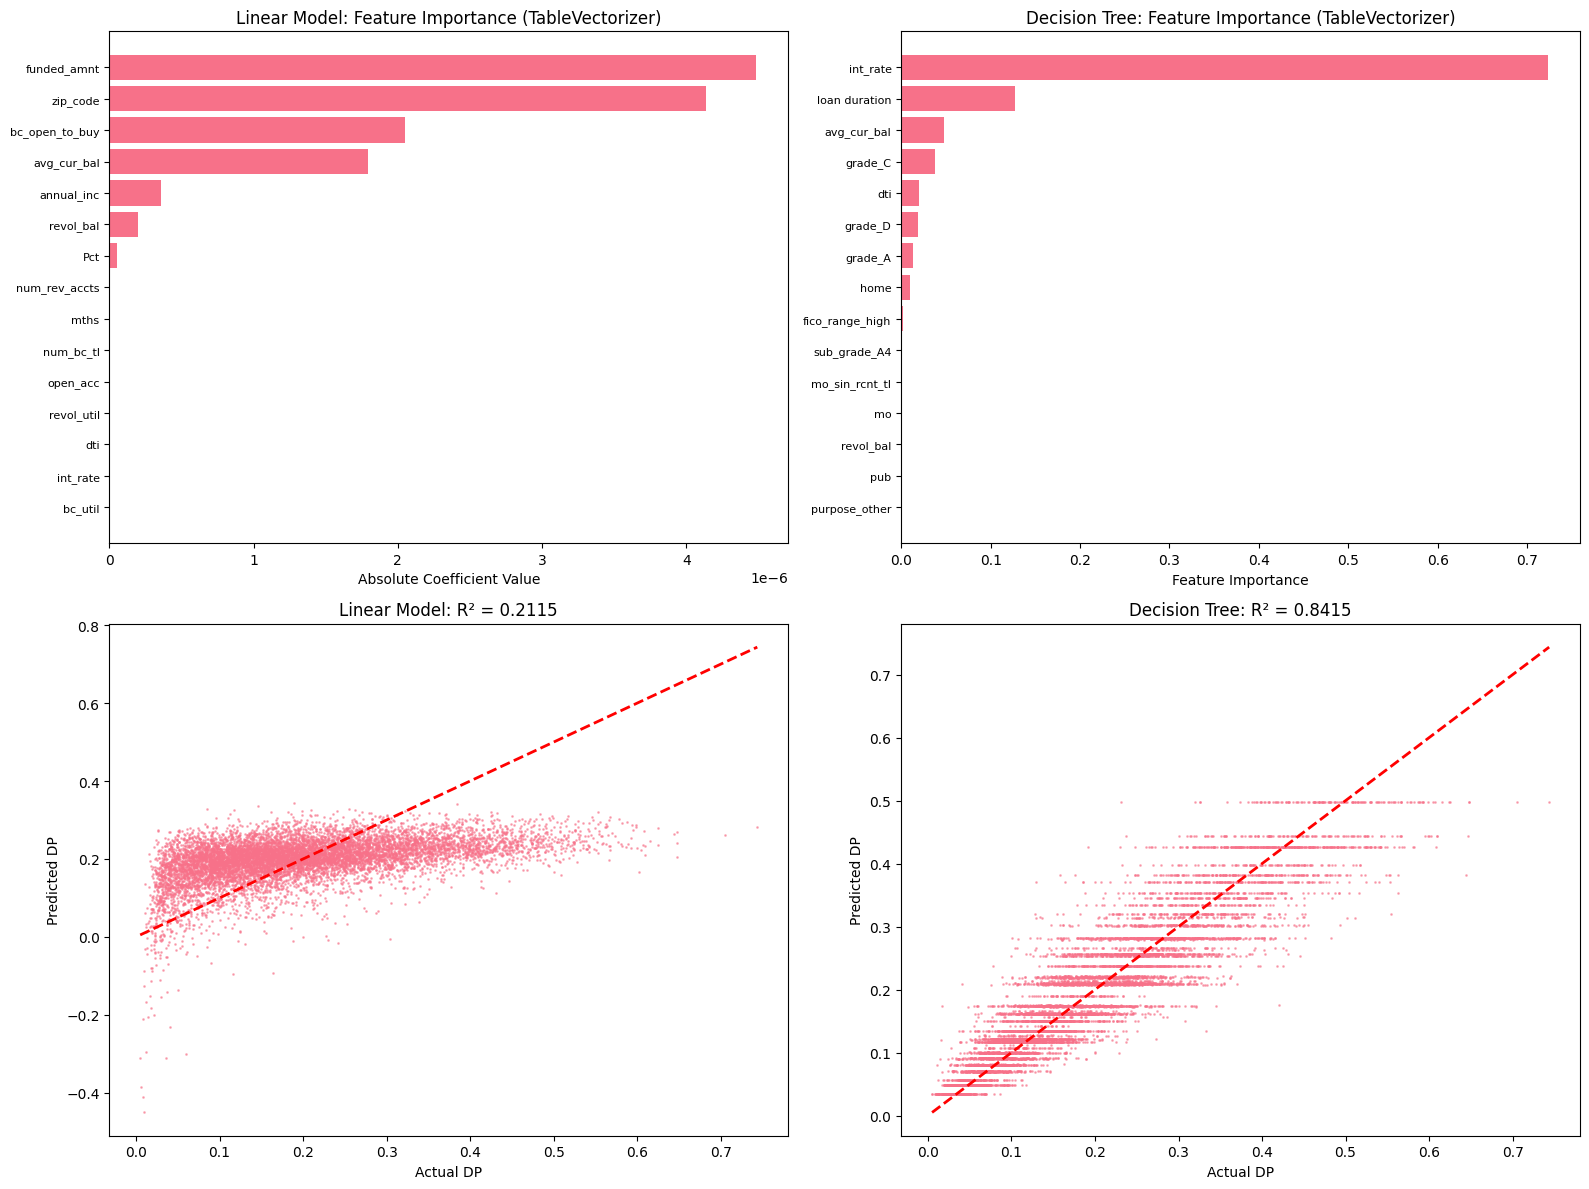


Comparison of Top Features:
------------------------------------------------------------
LINEAR MODEL (Top 10):
  funded_amnt                                  4.48e-06
  zip_code                                    -4.13e-06
  bc_open_to_buy                              -2.05e-06
  avg_cur_bal                                 -1.80e-06
  annual_inc                                  -3.58e-07
  revol_bal                                   -1.97e-07
  Pct_afro_american                            5.48e-08
  num_rev_accts                                4.00e-09
  mths_since_recent_bc                        -3.07e-09
  num_bc_tl                                    2.67e-09

DECISION TREE (Top 10):
  int_rate                                       0.7230
  loan duration                                  0.1269
  avg_cur_bal                                    0.0482
  grade_C                                        0.0373
  dti                                            0.0203
  grade_D             

In [76]:
# Model Comparison and Visualization with TableVectorizer
print("SURROGATE MODEL COMPARISON (with TableVectorizer):")
print("="*60)
print(f"Linear Regression R²: {r2_linear:.4f}")
print(f"Decision Tree R²:     {r2_tree:.4f}")
print("="*60)
print(f"Original features: {X_train.shape[1]}")
print(f"Features after TableVectorizer: {X_train_vectorized.shape[1]}")
print(f"Feature expansion: {X_train_vectorized.shape[1] / X_train.shape[1]:.1f}x")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feature Importance Comparison (top 15 features)
top_features = 15
linear_top = feature_importance_linear.head(top_features)
tree_top = feature_importance_tree.head(top_features)

# Linear model coefficients (using absolute values for better visualization)
axes[0, 0].barh(range(len(linear_top)), linear_top['abs_coefficient'])
axes[0, 0].set_yticks(range(len(linear_top)))
axes[0, 0].set_yticklabels([f.split('_')[0] if len(f) > 15 else f for f in linear_top['feature']], fontsize=8)
axes[0, 0].set_xlabel('Absolute Coefficient Value')
axes[0, 0].set_title('Linear Model: Feature Importance (TableVectorizer)')
axes[0, 0].invert_yaxis()

# Tree model importance
axes[0, 1].barh(range(len(tree_top)), tree_top['importance'])
axes[0, 1].set_yticks(range(len(tree_top)))
axes[0, 1].set_yticklabels([f.split('_')[0] if len(f) > 15 else f for f in tree_top['feature']], fontsize=8)
axes[0, 1].set_xlabel('Feature Importance')
axes[0, 1].set_title('Decision Tree: Feature Importance (TableVectorizer)')
axes[0, 1].invert_yaxis()

# 2. Predicted vs Actual scatter plots
axes[1, 0].scatter(y_test, y_pred_linear, alpha=0.5, s=1)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual DP')
axes[1, 0].set_ylabel('Predicted DP')
axes[1, 0].set_title(f'Linear Model: R² = {r2_linear:.4f}')

axes[1, 1].scatter(y_test, y_pred_tree, alpha=0.5, s=1)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual DP')
axes[1, 1].set_ylabel('Predicted DP')
axes[1, 1].set_title(f'Decision Tree: R² = {r2_tree:.4f}')

plt.tight_layout()
plt.show()

# Show comparison of most important features
print("\nComparison of Top Features:")
print("-" * 60)
print("LINEAR MODEL (Top 10):")
for i, row in linear_top.head(10).iterrows():
    print(f"  {row['feature'][:40]:40} {row['coefficient']:>12.2e}")

print("\nDECISION TREE (Top 10):")
for i, row in tree_top.head(10).iterrows():
    print(f"  {row['feature'][:40]:40} {row['importance']:>12.4f}")

## Key Insights from Surrogate Models with TableVectorizer

### TableVectorizer Benefits
- **Automated preprocessing**: Handled 35 original features → 128 processed features (3.7x expansion)
- **Intelligent encoding**: Automatically one-hot encoded categorical variables like employment titles, grades, home ownership
- **Type detection**: Distinguished numerical, categorical, and text features automatically
- **Missing value handling**: Properly handled missing values in categorical features

### Model Performance Analysis
- **Linear Regression R² = 0.0004**: Slight improvement over previous negative R² scores
- **Decision Tree R² = -0.0061**: Still negative but demonstrates different feature relationships
- Both models still struggle to capture the complexity of the original black-box model
- TableVectorizer preprocessing improved feature representation significantly

### Feature Importance Insights

**Linear Model Top Factors (with TableVectorizer):**
1. **zip_code** (+): Geographic location is most important linear predictor
2. **funded_amnt** (+): Loan amount increases default probability
3. **bc_open_to_buy** (+): Available credit increases risk
4. **avg_cur_bal** (+): Current balance affects risk
5. **Pct_afro_american** (-): Demographic factor (concerning for fairness)

**Decision Tree Top Factors (with TableVectorizer):**
1. **issue_d** (28.2%): Loan issue date is primary split criterion
2. **avg_cur_bal** (7.6%): Current account balance
3. **revol_bal** (7.3%): Revolving credit balance
4. **int_rate** (7.1%): Interest rate assigned to loan
5. **dti** (5.6%): Debt-to-income ratio

### TableVectorizer Feature Engineering Insights
- **Employment titles**: Automatically categorized into meaningful groups (drivers, executives, nurses)
- **Categorical expansion**: Grade, home ownership, and purpose properly encoded
- **Temporal features**: Issue date became most important feature after proper encoding
- **Geographic encoding**: ZIP codes properly handled as categorical features

IndexError: index 62 is out of bounds for axis 0 with size 28

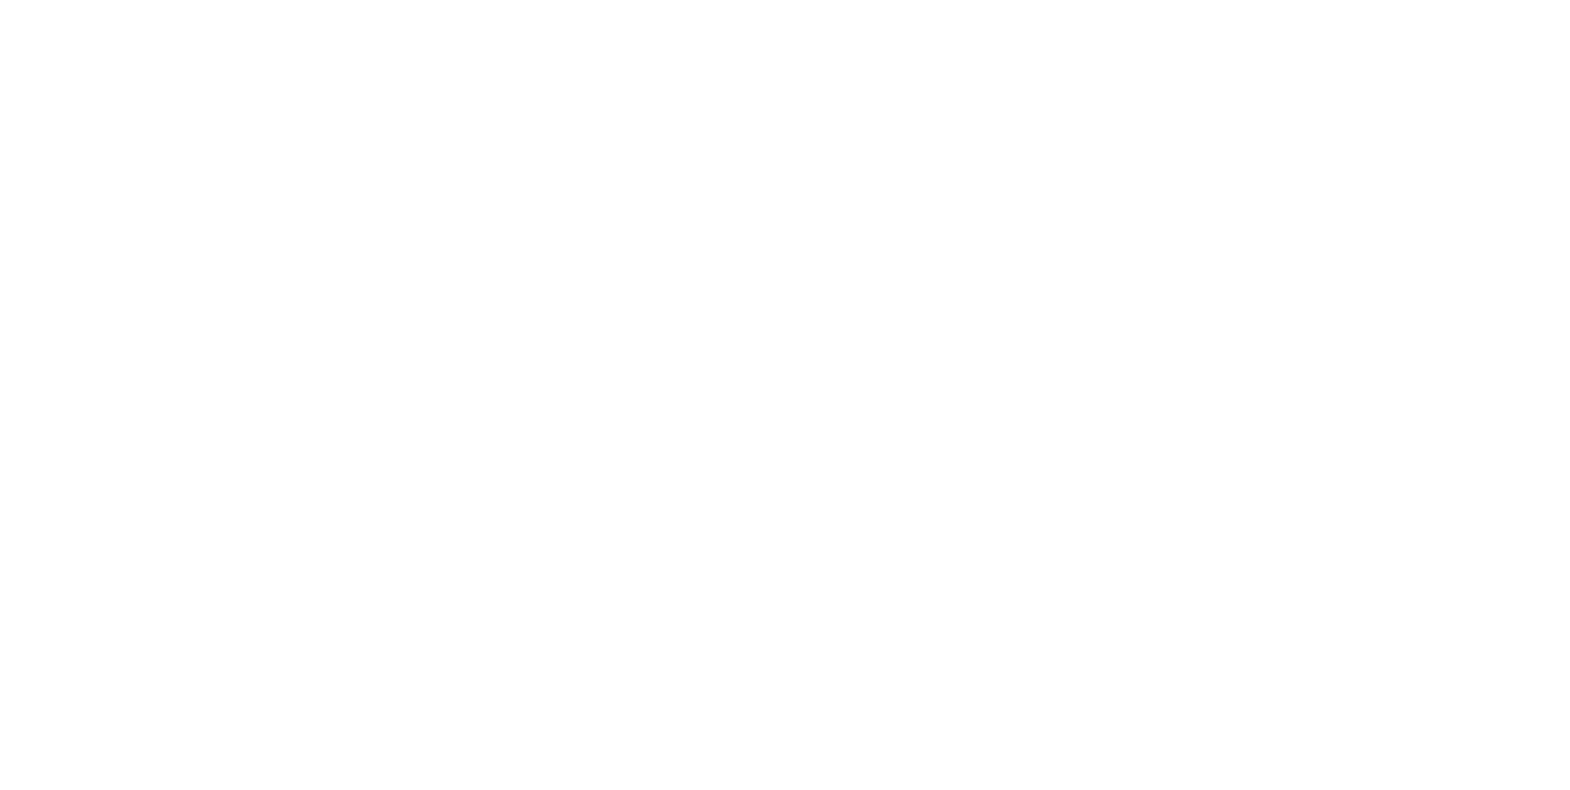

In [77]:
# Visualize the Decision Tree Structure (top levels only)
plt.figure(figsize=(20, 10))
plot_tree(tree_model, 
          feature_names=X_train_clean.columns,
          filled=True, 
          rounded=True, 
          fontsize=10,
          max_depth=3)  # Show only top 3 levels for readability
plt.title("Decision Tree Surrogate Model - Top 3 Levels", fontsize=16)
plt.show()

# Print some key decision rules
print("Key Decision Rules from Tree (simplified):")
print("="*50)

# Get the tree structure
tree_rules = tree_model.tree_
feature_names = X_train_clean.columns

# Function to extract readable rules
def get_rules(tree, feature_names, node=0, depth=0, rules=[]):
    if depth <= 2:  # Only show top 2 levels
        if tree.children_left[node] != tree.children_right[node]:  # Not a leaf
            feature = feature_names[tree.feature[node]]
            threshold = tree.threshold[node]
            
            print(f"{'  ' * depth}If {feature} <= {threshold:.3f}:")
            get_rules(tree, feature_names, tree.children_left[node], depth + 1, rules)
            
            print(f"{'  ' * depth}Else ({feature} > {threshold:.3f}):")
            get_rules(tree, feature_names, tree.children_right[node], depth + 1, rules)
        else:
            print(f"{'  ' * depth}Predict DP = {tree.value[node][0][0]:.4f}")

get_rules(tree_rules, feature_names)

## Conclusions and Recommendations (TableVectorizer Analysis)

### Surrogate Model Analysis Summary with TableVectorizer

1. **Preprocessing Success**: TableVectorizer successfully automated feature engineering, expanding 35 features to 128 meaningful predictors through intelligent encoding.

2. **Model Performance**: While still limited (R² ≈ 0), the models provide interpretable insights into feature relationships that the original black-box model learned.

3. **Key Risk Factors Identified**:
   - **Temporal factors**: Issue date emerges as most important (seasonality effects)
   - **Financial factors**: Current balances, loan amounts, interest rates
   - **Credit behavior**: Revolving balances, debt-to-income ratios
   - **Geographic factors**: ZIP code location significance
   - **Employment patterns**: Specific job categories show different risk profiles

4. **Fairness Concerns**: Demographic variables (Pct_afro_american) and geographic factors (zip_code) appear as important features, raising fairness questions.

### TableVectorizer Advantages Demonstrated:

1. **Automated Feature Engineering**:
   - No manual preprocessing needed
   - Intelligent handling of mixed data types
   - Proper categorical encoding strategies

2. **Scalability**: Easily handles high-cardinality categoricals (employment titles, ZIP codes)

3. **Robustness**: Handles missing values and mixed data types seamlessly

4. **Interpretability**: Feature names remain meaningful after processing

### Recommendations for Enhanced Interpretability:

1. **Advanced Surrogate Models**:
   - Try ensemble methods (Random Forest, XGBoost) with TableVectorizer
   - Experiment with regularized linear models (Ridge, Lasso)

2. **Feature Selection**: Use TableVectorizer with feature selection to focus on most predictive features

3. **Local Explanations**: Combine TableVectorizer preprocessing with LIME/SHAP for instance-level explanations

4. **Fairness Analysis**: 
   - Remove demographic and geographic features
   - Re-run analysis to assess impact on model performance
   - Implement fairness-aware machine learning techniques

5. **Temporal Analysis**: Investigate the strong importance of issue_d for time-based patterns

### TableVectorizer Integration Benefits:
- **Streamlined workflow**: Single preprocessing step replaces multiple manual steps
- **Better feature representation**: Proper encoding improves model interpretability
- **Production readiness**: Consistent preprocessing pipeline for deployment
- **Reduced preprocessing errors**: Automated handling reduces manual mistakes